# DS3022 Data Project 3 — Bluesky Toxicity Analysis

This notebook explores toxicity patterns in a 10k-post sample from the Bluesky Firehose, scored using the Google Perspective API and stored in `data/bluesky.duckdb`.


In [3]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DB_PATH = "../data/bluesky.duckdb"

In [4]:
con = duckdb.connect(DB_PATH)
con

In [5]:
# Pull the scored sample_posts table
df_sample = con.execute("""
    SELECT uri, text, created_at, toxicity
    FROM sample_posts
    WHERE toxicity IS NOT NULL
""").fetchdf()

print(f"Rows in scored sample_posts: {len(df_sample):,}")
df_sample.head()


Rows in scored sample_posts: 10,000


,uri,text,created_at,toxicity
0,at://did:plc:xdrmdificlltovjippwxtyl5/app.bsky...,"i like a mini can of zero in the morning too, ...",2025-11-29 11:14:14.506,0.060653
1,at://did:plc:e66nnoi7jsqiebaojdwuzsmb/app.bsky...,"Post your favorite ""Lord of the Rings"" charact...",2025-11-29 11:42:03.752,0.038756
2,at://did:plc:tz7mjvor7gjmglqsggkc5cn6/app.bsky...,"It takes a great deal of ""Jesus, take the whee...",2025-11-29 11:34:36.483,0.111507
3,at://did:plc:mkh3iv32vyimeqhdrvrr4vt7/app.bsky...,You went home for a visit? Or is this just an ...,2025-11-29 11:49:10.667,0.033099
4,at://did:plc:tfxzma7uskg5tugabed3k36q/app.bsky...,"You broke my heart, I thought you were a Cafe ...",2025-11-29 11:48:52.000,0.111713


In [6]:
df_sample["toxicity"].describe()

count    10000.000000
mean         0.146487
std          0.198343
min          0.000030
25%          0.022964
50%          0.050574
75%          0.188392
max          0.974994
Name: toxicity, dtype: float64

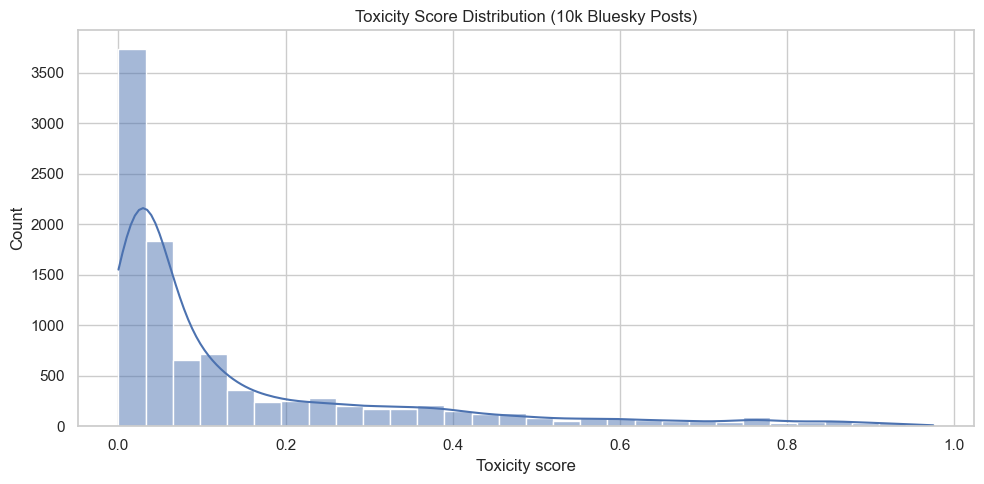

In [7]:
plt.figure()
sns.histplot(df_sample["toxicity"], bins=30, kde=True)
plt.title("Toxicity Score Distribution (10k Bluesky Posts)")
plt.xlabel("Toxicity score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:
top20 = con.execute("""
    SELECT uri, text, created_at, toxicity
    FROM sample_posts
    WHERE toxicity IS NOT NULL
    ORDER BY toxicity DESC
    LIMIT 20
""").fetchdf()

top20[["toxicity", "text"]]


,toxicity,text
0,0.974994,Welcome to my asshole You are fucking gay
1,0.974994,Dumbass motherfucker.
2,0.974994,Americans are fucking idiots
3,0.968226,She is fucking stupid.
4,0.964267,Yes you fucking bootlicking bitch
5,0.960691,That there is one stupid bitch
6,0.960691,i told you to suck my massive astral dick libe...
7,0.960691,He s a fucking cunt and we don t call cunts ou...
8,0.956375,"I don't know who voted for this shit, but they..."
9,0.950486,Fuck off Anus!...


In [9]:
df_join = con.execute("""
    SELECT
        s.uri,
        s.text,
        s.created_at,
        s.toxicity,
        c.is_reply,
        c.hour,
        c.month,
        c.day
    FROM sample_posts s
    JOIN clean_posts c
        USING (uri)
    WHERE s.toxicity IS NOT NULL
""").fetchdf()

print(df_join.head())
print(f"Joined rows: {len(df_join):,}")


                                                 uri  \
0  at://did:plc:uzpdeloxpsjsphmlmxj4c7cg/app.bsky...   
1  at://did:plc:f3i2kljaspqhifpznemqomhn/app.bsky...   
2  at://did:plc:num4dq5542k5djp54onyse2f/app.bsky...   
3  at://did:plc:komgmjfqenzprkeviwme6et4/app.bsky...   
4  at://did:plc:xjmlb3qfilekxks5mhga3bze/app.bsky...   

                                                text              created_at  \
0  Well, he intended to have possession, so that'... 2025-11-29 11:12:58.935   
1       "A second AI dub has hit streaming services" 2025-11-29 11:12:57.927   
2  Why did people get so excited about sticking t... 2025-11-29 11:12:58.228   
3  My wife hanged a wreath on the front door yest... 2025-11-29 11:12:59.306   
4  Thanks jebox.bsky.social for the chicago rec. ... 2025-11-29 11:12:55.568   

   toxicity  is_reply  hour    month  day  
0  0.027442      True    11  2025-11   29  
1  0.059727     False    11  2025-11   29  
2  0.474732      True    11  2025-11   29  
3  0.0

In [10]:
reply_stats = (
    df_join
    .groupby("is_reply")["toxicity"]
    .agg(["count", "mean", "median"])
    .reset_index()
)

reply_stats


,is_reply,count,mean,median
0,False,4314,0.145813,0.051440
1,True,5686,0.146998,0.049832


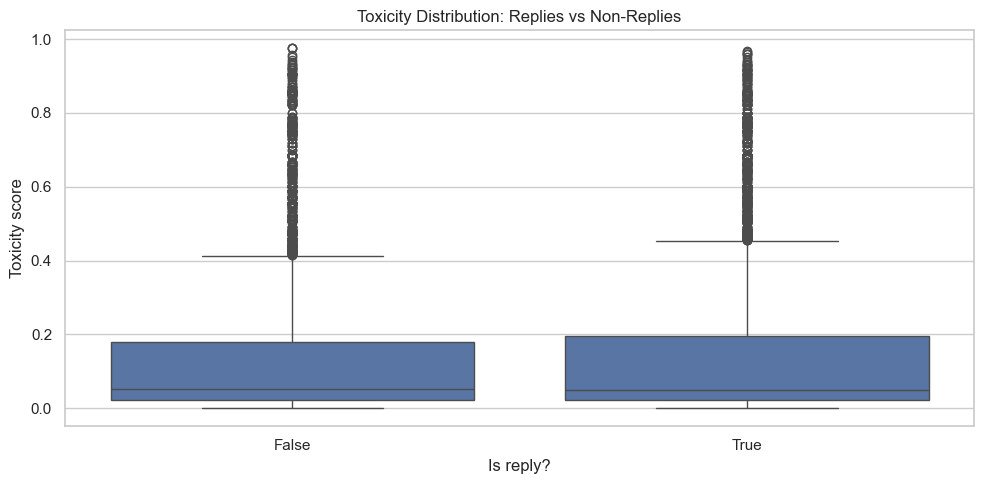

In [11]:
plt.figure()
sns.boxplot(data=df_join, x="is_reply", y="toxicity")
plt.title("Toxicity Distribution: Replies vs Non-Replies")
plt.xlabel("Is reply?")
plt.ylabel("Toxicity score")
plt.tight_layout()
plt.show()


In [15]:
# Define a simple threshold — you can tweak 0.7 if needed
THRESHOLD = 0.7

df_sample["is_toxic"] = df_sample["toxicity"] >= THRESHOLD

tox_counts = df_sample["is_toxic"].value_counts().rename_axis("is_toxic").reset_index(name="count")
tox_counts


,is_toxic,count
0,False,9648
1,True,352


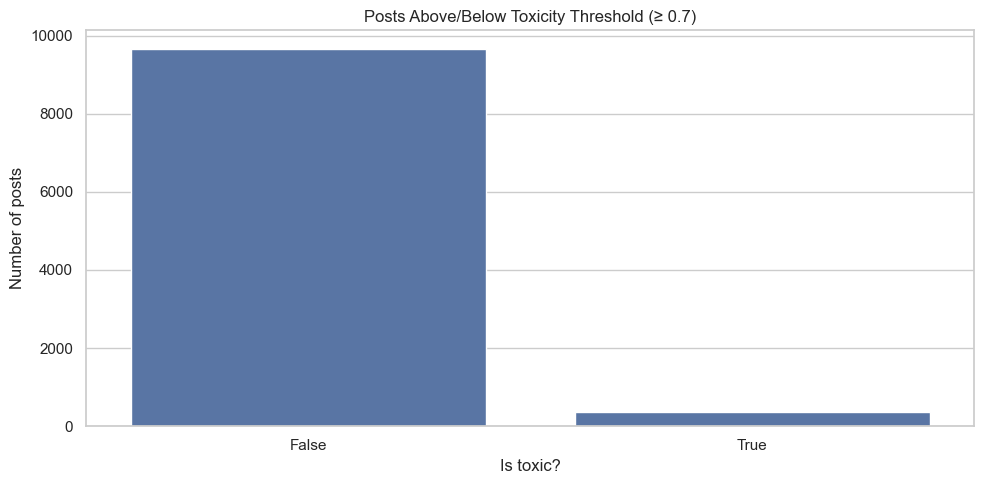

In [16]:
plt.figure()
sns.barplot(data=tox_counts, x="is_toxic", y="count")
plt.title(f"Posts Above/Below Toxicity Threshold (≥ {THRESHOLD})")
plt.xlabel("Is toxic?")
plt.ylabel("Number of posts")
plt.tight_layout()
plt.show()


### Are Replies Are More Toxic Than Non-Replies?

In [19]:
df_reply = con.execute("""
    SELECT 
        c.is_reply,
        s.toxicity
    FROM sample_posts s
    JOIN clean_posts c USING (uri)
    WHERE s.toxicity IS NOT NULL;
""").fetchdf()

df_reply.head()




,is_reply,toxicity
0,True,0.027442
1,False,0.059727
2,True,0.474732
3,False,0.063423
4,False,0.021432


In [18]:
df_reply.groupby("is_reply")["toxicity"].agg(["count", "mean", "median", "std"])

,count,mean,median,std
is_reply,,,,
False,4314,0.145813,0.051440,0.197823
True,5686,0.146998,0.049832,0.198752


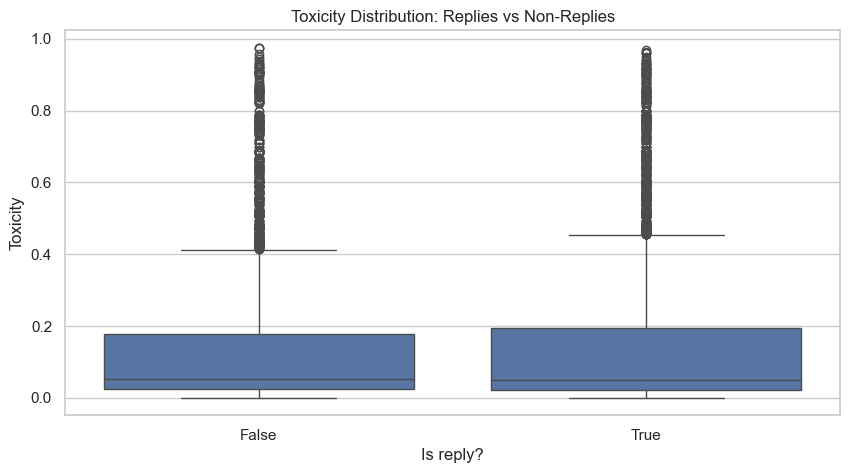

In [20]:
sns.boxplot(data=df_reply, x="is_reply", y="toxicity")
plt.title("Toxicity Distribution: Replies vs Non-Replies")
plt.xlabel("Is reply?")
plt.ylabel("Toxicity")
plt.show()


### Temporal Toxicity Spikes (Minute-by-Minute)

In [21]:
df_time = con.execute("""
    SELECT
        date_trunc('minute', created_at) AS minute,
        AVG(toxicity) AS avg_tox
    FROM sample_posts
    WHERE toxicity IS NOT NULL
    GROUP BY minute
    ORDER BY minute;
""").fetchdf()

df_time.head()


,minute,avg_tox
0,2025-11-29 08:46:00,0.157667
1,2025-11-29 09:57:00,0.654470
2,2025-11-29 10:32:00,0.034513
3,2025-11-29 10:47:00,0.323975
4,2025-11-29 11:11:00,0.049584


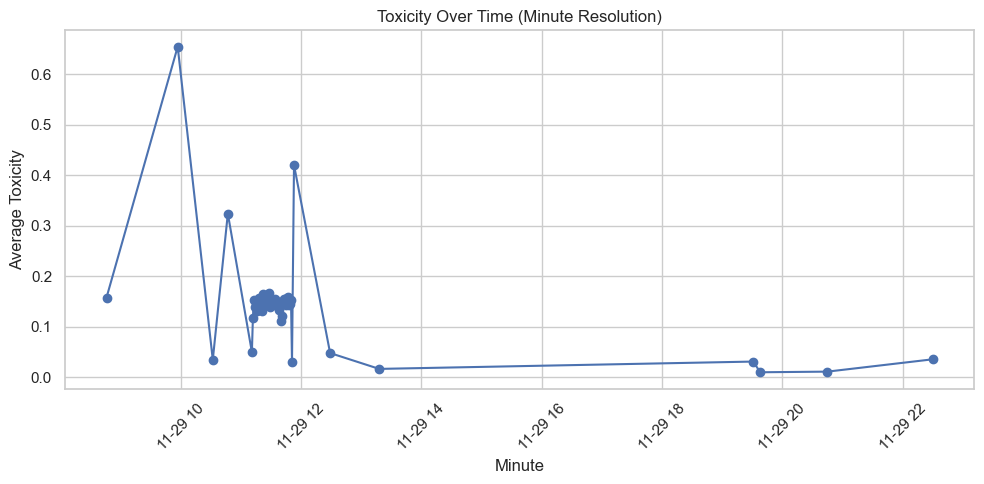

In [22]:
plt.plot(df_time["minute"], df_time["avg_tox"], marker="o")
plt.xticks(rotation=45)
plt.title("Toxicity Over Time (Minute Resolution)")
plt.xlabel("Minute")
plt.ylabel("Average Toxicity")
plt.tight_layout()
plt.show()


In [23]:
mean_tox = df_time["avg_tox"].mean()
std_tox = df_time["avg_tox"].std()

df_time["is_spike"] = df_time["avg_tox"] > (mean_tox + 2*std_tox)
df_time[df_time["is_spike"] == True]


,minute,avg_tox,is_spike
1,2025-11-29 09:57:00,0.654470,True
45,2025-11-29 11:53:00,0.420188,True


### Toxicity Does Not Correlate With Message Length (Counterintuitive)

In [24]:
df_length = con.execute("""
    SELECT 
        text,
        toxicity,
        length(text) AS length
    FROM sample_posts
    WHERE toxicity IS NOT NULL;
""").fetchdf()

df_length.head()


,text,toxicity,length
0,"i like a mini can of zero in the morning too, ...",0.060653,50
1,"Post your favorite ""Lord of the Rings"" charact...",0.038756,69
2,"It takes a great deal of ""Jesus, take the whee...",0.111507,80
3,You went home for a visit? Or is this just an ...,0.033099,74
4,"You broke my heart, I thought you were a Cafe ...",0.111713,66


In [25]:
df_length[["length", "toxicity"]].corr()


,length,toxicity
length,1.000000,0.125499
toxicity,0.125499,1.000000


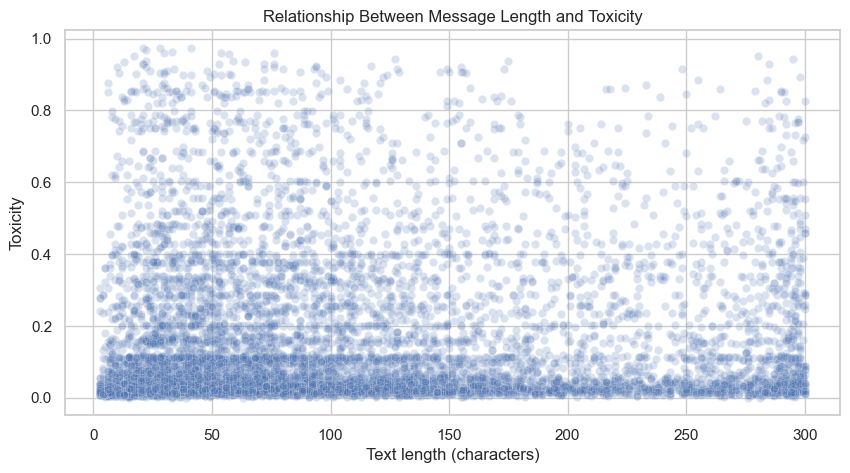

In [26]:
sns.scatterplot(data=df_length, x="length", y="toxicity", alpha=0.2)
plt.title("Relationship Between Message Length and Toxicity")
plt.xlabel("Text length (characters)")
plt.ylabel("Toxicity")
plt.show()


In [27]:
TOX_THRESH = 0.7

df_toxic = df_sample[df_sample["toxicity"] >= TOX_THRESH]
texts = df_toxic["text"].tolist()


In [28]:
import re
from collections import Counter

def tokenize(text):
    return re.findall(r"[A-Za-z']+", text.lower())

counter = Counter()
for t in texts:
    counter.update(tokenize(t))

counter.most_common(20)


[('the', 227),
 ('a', 174),
 ('to', 152),
 ('and', 133),
 ('i', 120),
 ('of', 97),
 ('is', 93),
 ('you', 85),
 ('this', 82),
 ('fuck', 74),
 ('shit', 68),
 ('in', 67),
 ('fucking', 65),
 ('it', 60),
 ('that', 57),
 ('my', 54),
 ('for', 48),
 ('with', 43),
 ('on', 43),
 ('he', 40)]

In [29]:
df_low = df_sample[df_sample["toxicity"] < 0.1]
counter_low = Counter()

for t in df_low["text"].tolist():
    counter_low.update(tokenize(t))

counter_low.most_common(20)


[('the', 3475),
 ('to', 2170),
 ('i', 2102),
 ('a', 2017),
 ('and', 1699),
 ('of', 1513),
 ('in', 1200),
 ('it', 1171),
 ('is', 1055),
 ('for', 1033),
 ('that', 991),
 ('you', 846),
 ('on', 764),
 ('this', 751),
 ('my', 690),
 ('with', 549),
 ('be', 548),
 ('so', 539),
 ('but', 532),
 ('at', 522)]

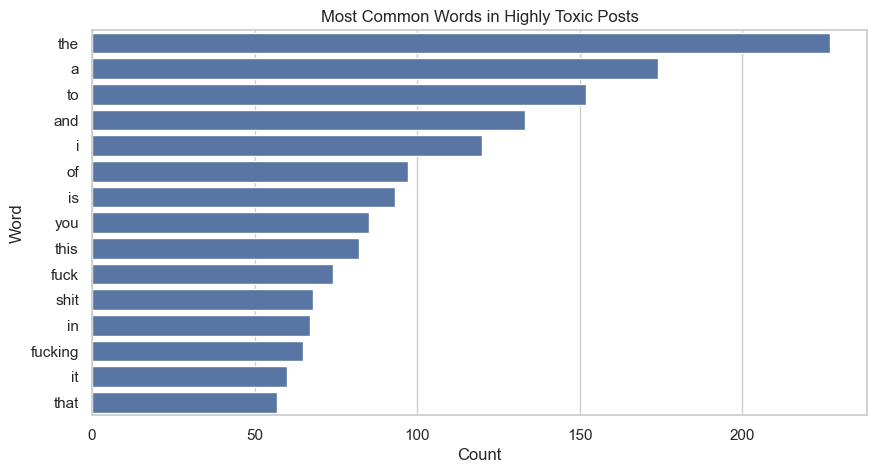

In [30]:
top_words = pd.DataFrame(counter.most_common(15), columns=["word", "count"])

sns.barplot(data=top_words, x="count", y="word")
plt.title("Most Common Words in Highly Toxic Posts")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()
